In [1]:
# RNN을 train하여 영화 리뷰 dataset에서 감정을 분석

import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

In [2]:
# 그래프를 그리기 위한 함수
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [3]:
# TFDS dataset 다운로드
dataset, info = tfds.load('imdb_reviews', with_info = True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteOGO97J/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteOGO97J/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteOGO97J/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
# dataset의 한 리뷰의 text, label pair 출력
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [6]:
# training 할 데이터를 shuffle 하고 batch size에 맞게 batch 생성
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'There may be spoilers!<br /><br />Charlie Fineman (Adam Sandler), who lost his family in a tragedy, (the terrorist attacks of Sept. 11), still grieves over their deaths. He runs into his former college roommate, Alan Johnson (Don Cheadle), and the two rekindle their friendship. Alan vows to help his old friend come to terms with the terrible loss. This is a simplification of the basic story of Reign Over Me. <br /><br />This movie is, however, a story of how fate intercedes in our lives when we ourselves may be powerless do any thing about our own states of being. Alan is stuck in a life that he knows is no longer fulfilling. He feels friendless and out of touch with his own reality. He is unable to communicate with his wife and his associates at work. He can\'t express his feelings and as a result feels lost and distant from his own world. He chances upon Charlie on the streets of Manhattan while driving from his job. Eventually he meets and discovers that Charlie, (who ori

In [8]:
# 문장을 단어로 Tokenize 하는 과정
# padding과 unknown token을 전처리한 후 frequency에 따라 정렬
VOCAB_SIZE = 1000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
tokenizer.adapt(train_dataset.map(lambda text, label: text))

In [9]:
vocab = np.array(tokenizer.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [10]:
# layer에서 text를 index로 변환
# batch에서 가장 긴 text에 맞춰 padding
tokenized_example = tokenizer(example)[:3].numpy()
tokenized_example

array([[ 48, 194,  28, ...,   0,   0,   0],
       [ 51,  23,  76, ...,   0,   0,   0],
       [ 11,   7,  39, ...,   0,   0,   0]])

In [11]:
# original text와 tokenized 된 text 출력
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[tokenized_example[n]]))
  print()

Original:  b'There may be spoilers!<br /><br />Charlie Fineman (Adam Sandler), who lost his family in a tragedy, (the terrorist attacks of Sept. 11), still grieves over their deaths. He runs into his former college roommate, Alan Johnson (Don Cheadle), and the two rekindle their friendship. Alan vows to help his old friend come to terms with the terrible loss. This is a simplification of the basic story of Reign Over Me. <br /><br />This movie is, however, a story of how fate intercedes in our lives when we ourselves may be powerless do any thing about our own states of being. Alan is stuck in a life that he knows is no longer fulfilling. He feels friendless and out of touch with his own reality. He is unable to communicate with his wife and his associates at work. He can\'t express his feelings and as a result feels lost and distant from his own world. He chances upon Charlie on the streets of Manhattan while driving from his job. Eventually he meets and discovers that Charlie, (who o

In [12]:
# 모델 생성
# 1. encoder layer(tokenizer): text를 token index sequence로 변환
# 2. embedding layer: word의 의미를 고려해서 word index를 trainable vector로 만들어 줌
#                     training이 끝나면 비슷한 의미를 가진 단어들은 비슷한 벡터를 가짐
# 3. decoder(LSTM): element를 반복하여 input으로 받아 처리
#                   한 timestep의 output을 다음 timestep의 input으로 전달
# 4. decoder에서 sequence를 단일 벡터로 변환한 후 Dense layer에서 이 벡터를 classification

model = tf.keras.Sequential([
    tokenizer,
    tf.keras.layers.Embedding(
        input_dim=len(tokenizer.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [13]:
# embedding layer에서 다양한 sequence 길이를 처리하기 위해 masking 사용
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [14]:
# 문장을 두 번 predict
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.00275736]


In [15]:
# sample text를 padding을 사용하여 predict
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.00275736]


In [16]:
# 모델 compile
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [17]:
# training 진행 (epoch 10번)
# loss, accuracy와 validation loss, validation accuracy 출력
# loss: 0.3018, accuracy: 0.8747
# validation loss: 0.3300, validation accuracy: 0.8500
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 25s 50ms/step - loss: 0.6469 - accuracy: 0.5644 - val_loss: 0.5051 - val_accuracy: 0.7469
Epoch 2/10
391/391 [==============================] - 19s 48ms/step - loss: 0.4159 - accuracy: 0.8162 - val_loss: 0.3758 - val_accuracy: 0.8313
Epoch 3/10
391/391 [==============================] - 18s 46ms/step - loss: 0.3484 - accuracy: 0.8508 - val_loss: 0.3521 - val_accuracy: 0.8464
Epoch 4/10
391/391 [==============================] - 18s 45ms/step - loss: 0.3249 - accuracy: 0.8620 - val_loss: 0.3382 - val_accuracy: 0.8490
Epoch 5/10
391/391 [==============================] - 19s 47ms/step - loss: 0.3187 - accuracy: 0.8657 - val_loss: 0.3326 - val_accuracy: 0.8536
Epoch 6/10
391/391 [==============================] - 19s 47ms/step - loss: 0.3114 - accuracy: 0.8699 - val_loss: 0.3314 - val_accuracy: 0.8573
Epoch 7/10
391/391 [==============================] - 20s 50ms/step - loss: 0.3117 - accuracy: 0.8688 - val_loss: 0.3288 - val_accuracy:

In [18]:
# train된 모델에 대해 test 진행
# test loss: 0.3231, test accuracy: 0.8534
# test loss와 test accuracy가 validation loss와 validation accuracy와 유사한 것을 확인할 수 있다
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 29ms/step - loss: 0.3231 - accuracy: 0.8534
Test Loss: 0.32311877608299255
Test Accuracy: 0.8533599972724915


(0.0, 0.6641607969999314)

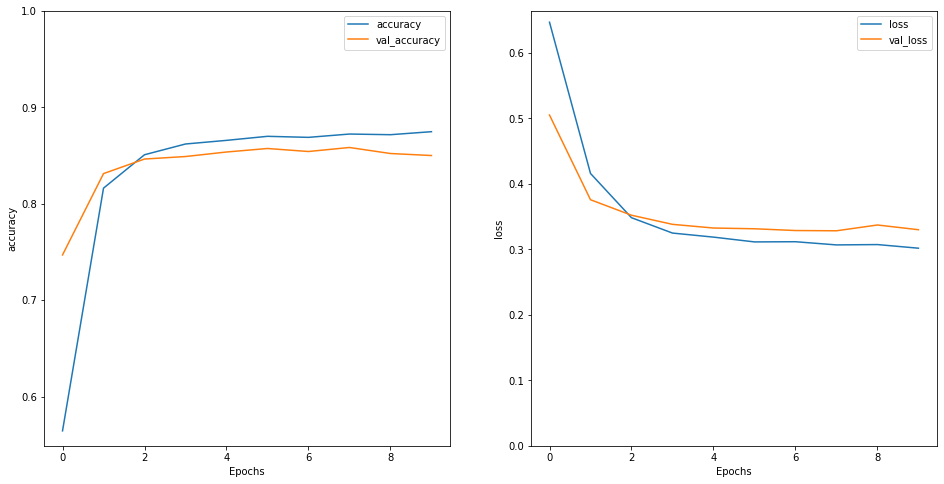

In [19]:
# accuracy와 validation accuracy, loss와 validation loss 그래프 출력
# accuracy와 validation accuracy가 비슷하게 증가
# loss와 validation loss가 비슷하게 감소
# overfitting이 일어나지 않은 것을 확인할 수 있다
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [20]:
# 새로운 문장에 대해 prediction
# prediction이 0보다 크면 positive, 0보다 작으면 negative 감정
# prediction: 0.35607 > 0 이므로 positive
# 문장이 영화에 대해 긍정적인 감정을 나타내므로 학습이 잘 된 것을 확인할 수 있다
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[0.35607]]
